In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import cv2
import sys
import copy
import json
import random
import rasterio
import numpy as np
import tifffile as tiff
from skimage.transform import rescale, resize

import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model, model_from_json

from keras.optimizers import SGD, Adam, RMSprop
from keras.backend import categorical_crossentropy, binary_crossentropy
from segmentation_models import Unet, FPN

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

Segmentation Models: using `keras` framework.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
sys.path.insert(0, '../')
from height_model_scripts.loss_functions import rmse
from height_model_scripts.metrics import F1_metric, RMSE, MAE
from height_model_scripts.height_model_scripts import Generator
from height_model_scripts.save_pred import save_pred, tif2geojson

### Split on test, train, validation

In [7]:
val_img_list = [
     'L2A_T38VNP_A007297_20180730T081559/',]
train_img_list = ['L2A_T38VNP_A016606_20180827T083208/',
     'L2A_T38VNP_A010986_20170730T082009/',
     'L2A_T38VNP_A005695_20160725T082012/',
     'L2A_T38VNP_A015748_20180628T082602/',
     'L2A_T38VNP_A013017_20190903T081606/']
train_img_list = ['/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/'+img_ind for img_ind in train_img_list]
val_img_list = ['/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/'+img_ind for img_ind in val_img_list]

## New model

In [8]:
batch_size=64 
num_channels=11

gdal_file_path = './'

generator = Generator(train_img_list, val_img_list, batch_size, num_channels, gdal_file_path=gdal_file_path)

generator.augm = False              # just geometric rotation is applied
generator.color_aug_prob = 1        # add color augm

generator.sharpen_flag = False      # flag to switch pansharpaning
generator.forest_mask = False       # add forest mask if it is provided

generator.lidar_coef = 0            # parameter for height resolution downsampling
generator.lidar_resolution = 10     # resolution of height data
generator.target_resolution = 10    # target resolution both for height and imagery
generator.clip_value = 40.          # the greatest height value

generator.IMG_ROW = 64
generator.IMG_COL = 64
generator.single_img = True

generator.height_name = 'lidar.tif'
generator.classifier_mode = 'regression'
generator.channels_list = ['B02_10m_norm.tif', 'B03_10m_norm.tif', 'B04_10m_norm.tif', 'B04_10m_norm.tif',
                          'B05_10m_norm.tif', 'B06_10m_norm.tif', 'B07_10m_norm.tif', 'B08_10m_norm.tif',
                          'B8A_10m_norm.tif', 'B11_10m_norm.tif', 'B12_10m_norm.tif']

In [9]:
generator.write_gdalinfo_file()

## Save generator parametrs

In [7]:
generator_state = copy.deepcopy(generator.__dict__)
del generator_state['data_gdal']
del generator_state['img_prob']

nb_name = 'regr_rgb_wv.ipynb'

save_file = nb_name.split('.')[0] + '.json'
with open(save_file, 'w') as f:
    json.dump(generator_state, f)

## Check outputs

Text(0.5,1,'lidar')

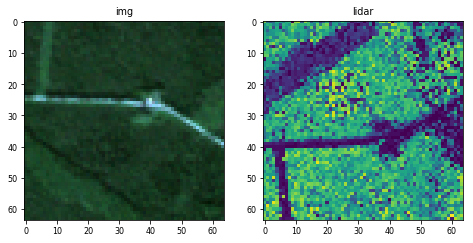

In [49]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((img_tmp[::-1][:,:,:3] - np.min(img_tmp[::-1][:,:,:3]))/(np.max(img_tmp[::-1][:,:,:3]) \
                                                                              - np.min(img_tmp[::-1][:,:,:3]))) #4,3,2
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f4a865892e8>)

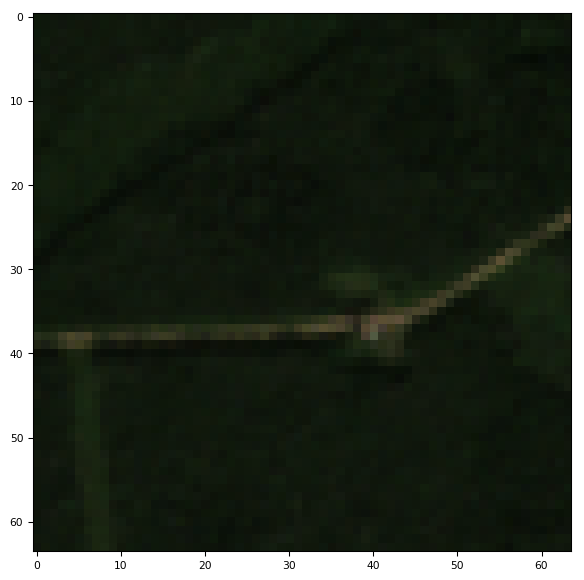

In [50]:
tiff.imshow(np.asarray([img_tmp[:,:,2], img_tmp[:,:,1], img_tmp[:,:,0]]))

Text(0.5,1,'lidar')

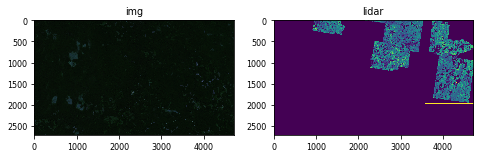

In [38]:
generator.full_img = True
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[2])
generator.full_img = False 

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((img_tmp[::-1][:,:,:3] - np.min(img_tmp[::-1][:,:,:3]))/(np.max(img_tmp[::-1][:,:,:3]) \
                                                                              - np.min(img_tmp[::-1][:,:,:3]))) #4,3,2
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Set model

In [10]:
model = Unet(backbone_name='inceptionresnetv2', input_shape=(None, None, num_channels), 
                  encoder_weights=None, activation='sigmoid')
loss =  rmse
opt = RMSprop(lr=0.001)
metrics=[loss]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

/opt/conda/lib/python3.6/site-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 11 input channels.
  str(input_shape[-1]) + ' input channels.')


In [11]:
model_name = 'regr_sentinel'
save_dir = '/home/user/data/example/data/Forestry_inventory/Height_model_paper/'

# csv logger
log_filename = os.path.join(save_dir, '{}.csv'.format(model_name))
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    ReduceLROnPlateau(patience=4,min_lr=1e-9,verbose=1,mode='min'), #pat 7
    ModelCheckpoint(save_dir + '{}.h5'.format(model_name),save_best_only=True,verbose=1),
    ModelCheckpoint(save_dir + '{}.hdf5'.format(model_name),save_best_only=True,verbose=1, save_weights_only=True),
    csv_logger
]

In [53]:
history=model.fit_generator(generator.train_gen(),epochs=25, #35, 25 20
                           steps_per_epoch=200,#200,
                           validation_data=generator.val_gen(),  #(valid_imgarr,valid_maskarr),
                           callbacks=callbacks, validation_steps=100)#30

Epoch 1/25
200/200 [==============================] - 392s 2s/step - loss: 0.1557 - rmse: 0.1557 - val_loss: 0.2536 - val_rmse: 0.2536

Epoch 00001: val_loss improved from inf to 0.25364, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_sentinel.h5

Epoch 00001: val_loss improved from inf to 0.25364, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_sentinel.hdf5
Epoch 2/25
200/200 [==============================] - 354s 2s/step - loss: 0.1440 - rmse: 0.1440 - val_loss: 0.1969 - val_rmse: 0.1969

Epoch 00002: val_loss improved from 0.25364 to 0.19685, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_sentinel.h5

Epoch 00002: val_loss improved from 0.25364 to 0.19685, saving model to /home/user/data/example/data/Forestry_inventory/Height_model_paper/regr_sentinel.hdf5
Epoch 3/25
200/200 [==============================] - 368s 2s/step - loss: 0.1401 - rmse: 0.1401 - val_los

KeyboardInterrupt: 

In [17]:
# serialize model to JSON without height
model_name += '_v1'
model_json = model.to_json()
with open(save_dir+"{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(save_dir+"{}.h5".format(model_name))
print("Saved model to disk")

Saved model to disk


In [12]:
model.load_weights(save_dir+"{}.h5".format(model_name)) 

## Evaluation

In [60]:
generator.augm  = False
prediction, full_mask = generator.pred_img(model=model, img_path=val_img_list[0])

In [63]:
val_img_list

['/home/user/data/projects/research-project/notebooks/Illarionova/usgs_sentinel/Left_shore/krasnoborsk/L2A_T38VNP_A007297_20180730T081559/']

Text(0.5,1,'lidar')

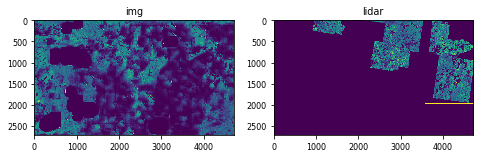

In [61]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((prediction[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow((full_mask[:,:,0]*generator.clip_value).clip(0, generator.clip_value))
a.set_title('lidar')

In [62]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 9.982
MAE 7.273


In [57]:
print('RMSE', RMSE(prediction*generator.clip_value, full_mask*generator.clip_value))
print('MAE', MAE(prediction*generator.clip_value, full_mask*generator.clip_value))

RMSE 9.872
MAE 6.967


In [58]:
generator.augm  = False
average_rmse = 0
average_mae = 0
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    cur_rmse = RMSE(prediction*generator.clip_value, full_mask*generator.clip_value)
    cur_mae = MAE(prediction*generator.clip_value, full_mask*generator.clip_value)
    average_rmse += cur_rmse
    average_mae += cur_mae
    print(ind, 'rmse: ', cur_rmse, ' mae: ', cur_mae)
generator.augm  = True

print('~~~~~~~~~~~~~~~~')
print('Average RMSE: ', round(average_rmse / len(val_img_list), 3))
print('Average MAE: ', round(average_mae / len(val_img_list), 3))

0 rmse:  9.872  mae:  6.967
~~~~~~~~~~~~~~~~
Average RMSE:  9.872
Average MAE:  6.967


In [85]:
mae = 0
for i in range(20):
    for img, mask in generator.val_gen():
        break
    pred = model.predict(img)
    mae += np.mean(np.abs(pred*40-mask*40))
mae /=20
print(mae)

4.149534530598854


In [84]:
mae

4.202937119415447

In [13]:
mbe = 0
for i in range(20):
    for img, mask in generator.val_gen():
        break
    pred = model.predict(img)
    mbe += np.mean(pred*40-mask*40)
mbe /=20
print(mbe)

0.7939170669600258


In [14]:
rmse = 0
for i in range(20):
    for img, mask in generator.val_gen():
        break
    pred = model.predict(img)
    rmse += (pred*40-mask*40)**2
rmse =np.sqrt(np.mean(rmse/20))
print(rmse)

5.782963548734561


In [15]:
mean_val = 0
for i in range(20):
    for img, mask in generator.val_gen():
        break
    mean_val += np.mean(mask)
mean_val /= 20
print(mean_val)

0.33043044090271


In [16]:
y_0 = 0
y_1 = 0
y_mean = 0
for i in range(20):
    for img, mask in generator.val_gen():
        break
    pred = model.predict(img)
    y_0 += (pred*40-mask*40)**2
    y_1 += (mask*40 - mean_val*40)**2
r2 = 1 - np.sum(y_0)/np.sum(y_1)
print(r2)

0.45275328242669377


In [79]:
for img, mask in generator.val_gen():
    break
pred = model.predict(img)

In [80]:
np.mean(np.abs(pred*40-mask*40))

4.077859587648163

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


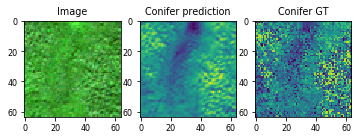

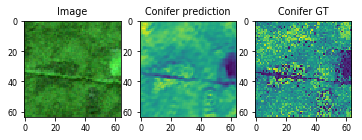

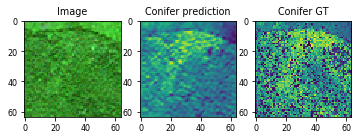

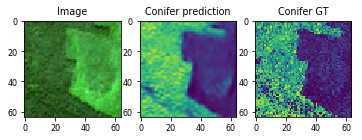

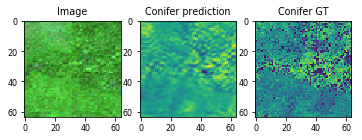

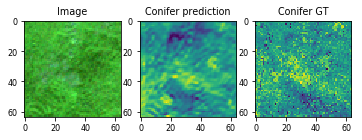

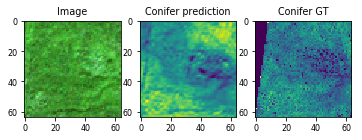

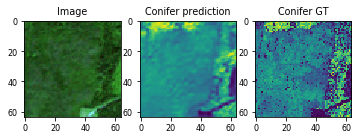

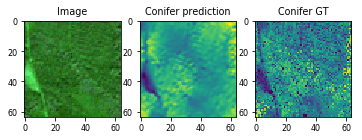

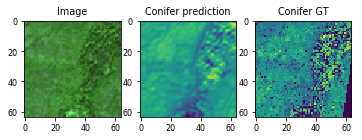

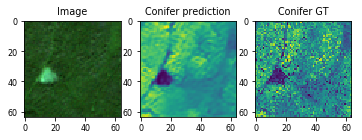

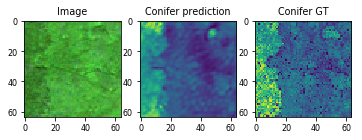

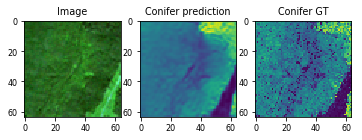

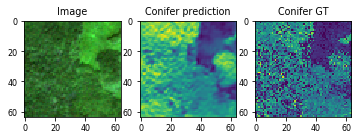

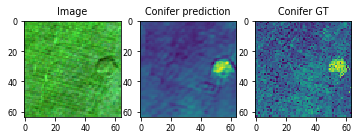

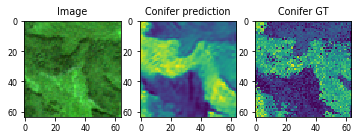

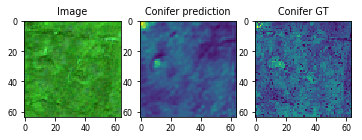

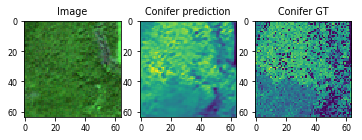

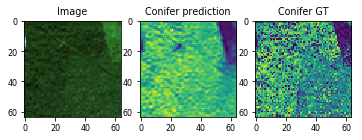

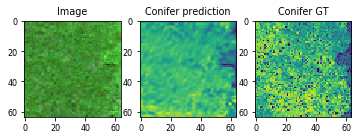

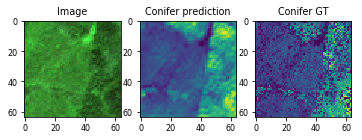

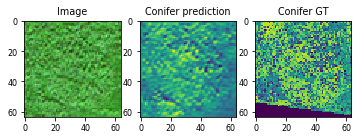

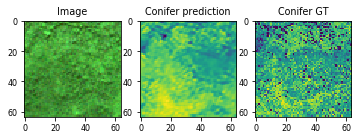

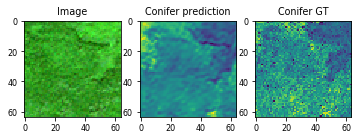

In [66]:
mae = 0
for num in range(1, 25):
    fig = plt.figure(figsize=(10, 10))
    a = fig.add_subplot(1, 5, 1)
    a.set_title('Image')
    imgplot = plt.imshow((img[num, :, :, 0:3] - np.min(img[num, :, :, 0:3]))/(np.max(img[num, :, :, 0:3]) 
                                                                           - np.min(img[num, :, :, 0:3])) )
    a = fig.add_subplot(1, 5, 2)
    a.set_title('Conifer prediction')
    imgplot = plt.imshow(pred[num,:,:,0]) #.imshow(pred[num,:,:,cl]>0.5) 
    a = fig.add_subplot(1, 5, 3)
    a.set_title('Conifer GT')
    imgplot = plt.imshow(mask[num,:,:,0])

Text(0.5,1,'lidar')

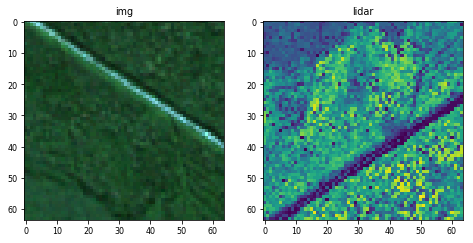

In [83]:
# check output
img_tmp, mask_tmp = generator.get_img_mask_array(train_img_list[0])

fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow((img_tmp[::-1][:,:,:3] - np.min(img_tmp[::-1][:,:,:3]))/(np.max(img_tmp[::-1][:,:,:3]) \
                                                                              - np.min(img_tmp[::-1][:,:,:3]))) #4,3,2
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(mask_tmp[:,:,0])
a.set_title('lidar')

## Save prediction

In [ ]:
json_file = open(save_dir+"{}.json".format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(save_dir+"{}.h5".format(model_name)) 

In [39]:
val_img_list

['/home/user/data/krasnoborsk/world_view/0/6_3',
 '/home/user/data/krasnoborsk/world_view/0/2_2',
 '/home/user/data/krasnoborsk/world_view/0/4_2',
 '/home/user/data/krasnoborsk/world_view/0/1_1']

In [57]:
r = tiff.imread('/home/user/data/krasnoborsk/world_view/0/2_2_channel_1.tif')
height = tiff.imread('/home/user/data/krasnoborsk/world_view/0/height_2_2.tif')

Text(0.5,1,'lidar')

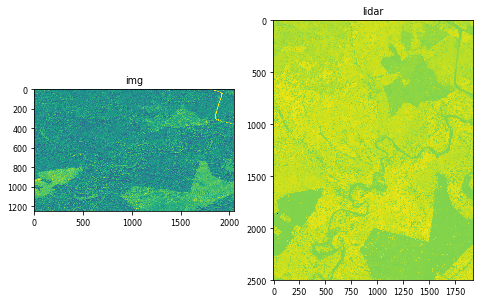

In [59]:
fig = plt.figure(figsize = (25,25))
a = fig.add_subplot(1, 6, 1)
imgplot = plt.imshow(r)
a.set_title('img')
a = fig.add_subplot(1, 6, 2)
imgplot = plt.imshow(height)
a.set_title('lidar')

In [65]:
generator.augm  = False
for ind, img_path in enumerate(val_img_list):
    prediction, full_mask = generator.pred_img(model=model, img_path=img_path)
    height_name = '/home/user/data/krasnoborsk/world_view/0/height_6_3.tif'
    save_pred(img_to_save=prediction[:,:,0]*generator.clip_value, save_dist='../images/tmp.tif', \
          info_img=height_name, crs=4326)
    tif2geojson(source_dir='../images/', tif_name='tmp', geojson_path='../images/tmp.geojson')
    break
generator.augm  = True

1918 2498 (2498, 1918)


In [66]:
tmp = tiff.imread('../images/tmp.tif')

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7fa4b308ddd8>)

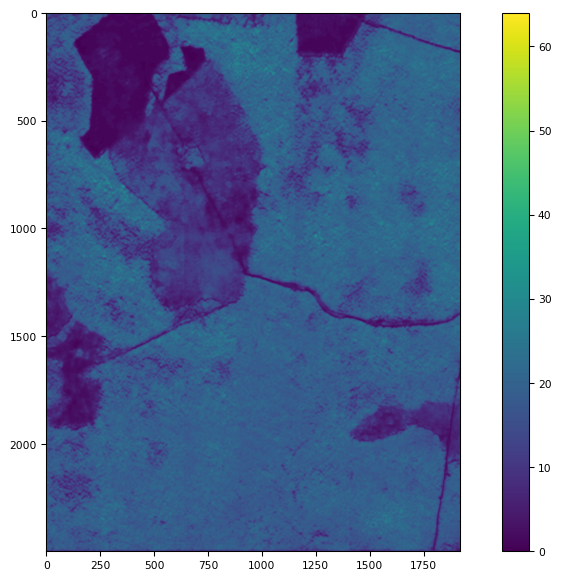

In [68]:
tiff.imshow(tmp.clip(0, 40))